In [1]:
import sys, os
from pathlib import Path
import torch
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

/home/viplab/pt-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load flooding configuration file from local device or gcs

In [2]:
from ml4floods.models.config_setup import get_default_config
import pkg_resources

# Set filepath to configuration files
# config_fp = 'path/to/worldfloods_template.json'
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)
config

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

{'experiment_name': 'worldfloods_demo_test',
 'seed': 12,
 'model_params': {'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_dice_loss',
   'channel_configuration': 'all',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'linear',
   'num_classes': 3,
   'max_epochs': 10,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 13},
  'train': True,
  'test': True},
 'data_params': {'loader_type': 'local',
  'num_workers': 4,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': 'ml4cc_data_lake',
  'path_to_splits': 'worldfloods',
  'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
  'input_folder': '

## Step 2: Setup Dataloader

In [3]:
config.experiment_name = 'training_flooding_bgriswir'
config.data_params.channel_configuration = 'bgriswir'
config.model_params.hyperparameters.channel_configuration = 'bgriswir'
config.model_params.hyperparameters.num_channels = 5
config.data_params.bucket_id = ""
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'bgriswir',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 5},
 'train': True,
 'test': True}

In [4]:
%%time

from ml4floods.models.dataset_setup import get_dataset

config.data_params.batch_size = 8 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/mnt/d/Flooding/worldfloods_v1_0" # local folder to download the data
config.data_params.train_test_split_file = "/mnt/d/Flooding/train_test_split_local.json"

config.data_params["download"] = {"train": True, "val": True, "test": True} # download only test data
# config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" # use this to train with all the data
config.data_params.num_workers = 4

# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
dataset = get_dataset(config.data_params)

train 194151  tiles
val 1284  tiles
test 11  tiles
CPU times: user 1.32 s, sys: 1.45 s, total: 2.77 s
Wall time: 1.03 s


## Verfify data loader

#### Verify training data
Data format here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [5]:
train_dl = dataset.train_dataloader()
train_dl_iter = iter(train_dl)
print(len(train_dl_iter))
batch_train = next(train_dl_iter)

# batch_train["image"].shape, batch_train["mask"].shape

24269


Verify validation data

In [6]:
val_dl = dataset.val_dataloader()

val_dl_iter = iter(val_dl)
print(len(val_dl_iter))
batch_val = next(val_dl_iter)

# batch_val["image"].shape, batch_val["mask"].shape

161


In [7]:
test_dl = dataset.test_dataloader()

test_dl_iter = iter(test_dl)
print(len(test_dl_iter))

batch_test = next(test_dl_iter)
# batch_test["image"].shape, batch_test["mask"].shape

11


### Plot batch by using ml4flood model 
check detail here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [8]:
import importlib
import matplotlib.pyplot as plt
from models import flooding_model
flooding_model = importlib.reload(flooding_model)

# batch_train_rgb = flooding_model.batch_to_unnorm_rgb(batch_train["image"])
# # batch_train_rgb.shape
# plt.imshow(batch_train_rgb[2])
# plt.show()

# batch_train_rgb_mask = flooding_model.batch_mask_to_rgb(batch_train["mask"])
# plt.imshow(batch_train_rgb_mask[2])
# plt.colorbar()
# plt.show()


## Step 3: Setup Model

In [9]:
 # folder to store the trained model (it will create a subfolder with the name of the experiment)
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'bgriswir',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 5},
 'train': True,
 'test': True}

In [10]:
config.model_params.model_folder = "train_models" 
os.makedirs("train_models", exist_ok=True)
config.model_params.test = False
config.model_params.train = True
config.model_params.hyperparameters.model_type = "unet" # Currently implemented: simplecnn, unet, linear
config.model_params.hyperparameters.metric_monitor = 'val_iou_loss' #IoU Loss
# config.model_params.hyperparameters.num_channels = 3

In [11]:
import copy
from models.flooding_model import WorldFloodsModel, DistilledTrainingModel, WorldFloodsModel2, WorldFloodsModel1
importlib.reload(flooding_model)
simple_model_params = copy.deepcopy(config.model_params)
simple_model_params['hyperparameters']['model_type']="unet_simple"

# model = DistilledTrainingModel(config.model_params, simple_model_params)
model = WorldFloodsModel2(config.model_params) # Focal loss and IoU loss
# model = WorldFloodsModel1(config.model_params) # Focal loss and Dice loss
net = model.network
net

num of channels:  5 , num of classes:  3


UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [12]:
# Compuatation complexity of network
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(net, (config.model_params.hyperparameters.num_channels, config.model_params.hyperparameters.max_tile_size, config.model_params.hyperparameters.max_tile_size), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

UNet(
  7.78 M, 100.000% Params, 42.55 GMac, 100.000% MACs, 
  (dconv_down1): Sequential(
    39.87 k, 0.512% Params, 2.62 GMac, 6.161% MACs, 
    (0): Conv2d(2.94 k, 0.038% Params, 192.94 MMac, 0.453% MACs, 5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 4.19 MMac, 0.010% MACs, inplace=True)
    (2): Conv2d(36.93 k, 0.474% Params, 2.42 GMac, 5.688% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 4.19 MMac, 0.010% MACs, inplace=True)
  )
  (dconv_down2): Sequential(
    221.44 k, 2.845% Params, 3.63 GMac, 8.537% MACs, 
    (0): Conv2d(73.86 k, 0.949% Params, 1.21 GMac, 2.844% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 2.1 MMac, 0.005% MACs, inplace=True)
    (2): Conv2d(147.58 k, 1.896% Params, 2.42 GMac, 5.683% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 2.1 MMac, 0.005% MACs, inplace=Tr

In [13]:
setup_weights_and_biases = False
if setup_weights_and_biases:
    import wandb
    from pytorch_lightning.loggers import WandbLogger

    # UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
    # wandb.login()
    # run = wandb.init()

    # Specifies who is logging the experiment to wandb
    config['wandb_entity'] = 'ml4floods'
    # Specifies which wandb project to log to, multiple runs can exist in the same project
    config['wandb_project'] = 'worldfloods-notebook-demo-project'

    wandb_logger = WandbLogger(
        name=config.experiment_name,
        project=config.wandb_project, 
        entity=config.wandb_entity
    )
else:
    wandb_logger = None

In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_iou_loss',
    mode='min',
#     prefix=''
)

early_stop_callback = EarlyStopping(
    monitor='val_iou_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)
# monitor='val_iou_loss'
# monitor='val_dice_loss'


callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

The trained model will be stored in train_models/training_flooding_bgriswir


In [15]:
from pytorch_lightning import Trainer

config.gpus = 2 # which gpu to use
# config.gpus = None # to not use GPU
config.model_params.hyperparameters.max_epochs = 40 # train for maximum 4 epochs

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    strategy='dp',
    accelerator='gpu',
    devices=config.gpus

    # gpus=config.gpus,
    # resume_from_checkpoint='/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=8-step=109214.ckpt'
)
# config
# https://wandb.ai/wandb/wandb-lightning/reports/Multi-GPU-Training-Using-PyTorch-Lightning--VmlldzozMTk3NTk
# resume_from_checkpoint='/home/eeaiserver/viplab_projects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=39-step=161799.ckpt'
# resume_from_checkpoint='~/Projects/satellite-knowledge-distillation/train_models/training_flooding_bgri/checkpoint/epoch=30-step=47026.ckpt'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, dataset)

/home/viplab/pt-gpu/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type | Params
---------------------------------
0 | network | UNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.137    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                     | 0/2 [00:00<?, ?it/s]

/home/viplab/pt-gpu/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  99%|█████████████████████████████████████████████▋| 24269/24430 [37:34<00:14, 10.76it/s, loss=0.117]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████| 24430/24430 [37:53<00:00, 10.74it/s, loss=0.117]

Epoch 0, global step 24269: 'val_iou_loss' reached 0.27215 (best 0.27215), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=0-step=24269-v1.ckpt' as top True


Epoch 1:  99%|█████████████████████████████████████████████▋| 24269/24430 [37:20<00:14, 10.83it/s, loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████| 24430/24430 [37:39<00:00, 10.81it/s, loss=0.124]

Epoch 1, global step 48538: 'val_iou_loss' was not in top True


Epoch 2:  99%|██████████████████████████████████████████████▋| 24269/24430 [36:47<00:14, 10.99it/s, loss=0.12]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████| 24430/24430 [37:06<00:00, 10.97it/s, loss=0.12]

Epoch 2, global step 72807: 'val_iou_loss' was not in top True


Epoch 3:  99%|█████████████████████████████████████████████▋| 24269/24430 [36:31<00:14, 11.07it/s, loss=0.131]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████| 24430/24430 [36:50<00:00, 11.05it/s, loss=0.131]

Epoch 3, global step 97076: 'val_iou_loss' was not in top True


Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.
Epoch 4:  99%|█████████████████████████████████████████████▋| 24269/24430 [36:28<00:14, 11.09it/s, loss=0.133]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████████████████████████████████████| 24430/24430 [36:48<00:00, 11.06it/s, loss=0.133]

Epoch 4, global step 121345: 'val_iou_loss' was not in top True


Epoch 5:  99%|██████████████████████████████████████████████▋| 24269/24430 [36:32<00:14, 11.07it/s, loss=0.13]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████| 24430/24430 [36:51<00:00, 11.04it/s, loss=0.13]

Epoch 5, global step 145614: 'val_iou_loss' was not in top True


Epoch 6:  99%|████████████████████████████████████████████▋| 24269/24430 [36:30<00:14, 11.08it/s, loss=0.0974]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████████████████████████████████████████| 24430/24430 [36:49<00:00, 11.06it/s, loss=0.0974]

Epoch 6, global step 169883: 'val_iou_loss' reached 0.24996 (best 0.24996), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=6-step=169883.ckpt' as top True


Epoch 7:  99%|██████████████████████████████████████████████▋| 24269/24430 [36:35<00:14, 11.06it/s, loss=0.11]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████| 24430/24430 [36:54<00:00, 11.03it/s, loss=0.11]

Epoch 7, global step 194152: 'val_iou_loss' was not in top True


Epoch 8:  99%|█████████████████████████████████████████████▋| 24269/24430 [36:28<00:14, 11.09it/s, loss=0.107]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████████████████████████████████████████| 24430/24430 [36:47<00:00, 11.06it/s, loss=0.107]

Epoch 8, global step 218421: 'val_iou_loss' was not in top True


Epoch 9:  99%|█████████████████████████████████████████████▋| 24269/24430 [36:24<00:14, 11.11it/s, loss=0.117]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████████████████████████████████████████| 24430/24430 [36:43<00:00, 11.09it/s, loss=0.117]

Epoch 9, global step 242690: 'val_iou_loss' was not in top True


Epoch 00010: reducing learning rate of group 0 to 2.5000e-05.
Epoch 10:  99%|████████████████████████████████████████████▋| 24269/24430 [36:09<00:14, 11.19it/s, loss=0.107]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|█████████████████████████████████████████████| 24430/24430 [36:28<00:00, 11.16it/s, loss=0.107]

Epoch 10, global step 266959: 'val_iou_loss' reached 0.24989 (best 0.24989), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=10-step=266959.ckpt' as top True


Epoch 11:  99%|████████████████████████████████████████████▋| 24269/24430 [36:46<00:14, 11.00it/s, loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|█████████████████████████████████████████████| 24430/24430 [37:05<00:00, 10.98it/s, loss=0.123]

Epoch 11, global step 291228: 'val_iou_loss' was not in top True


Epoch 12:  99%|████████████████████████████████████████████▋| 24269/24430 [36:45<00:14, 11.01it/s, loss=0.118]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|█████████████████████████████████████████████| 24430/24430 [37:04<00:00, 10.98it/s, loss=0.118]

Epoch 12, global step 315497: 'val_iou_loss' was not in top True


Epoch 13:  99%|█████████████████████████████████████████████▋| 24269/24430 [36:37<00:14, 11.04it/s, loss=0.12]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████████████████████████████████████████| 24430/24430 [36:57<00:00, 11.02it/s, loss=0.12]

Epoch 13, global step 339766: 'val_iou_loss' was not in top True


Epoch 00014: reducing learning rate of group 0 to 1.2500e-05.
Epoch 14:  99%|████████████████████████████████████████████▋| 24269/24430 [36:40<00:14, 11.03it/s, loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|█████████████████████████████████████████████| 24430/24430 [36:59<00:00, 11.01it/s, loss=0.123]

Epoch 14, global step 364035: 'val_iou_loss' was not in top True


Epoch 15:  99%|███████████████████████████████████████████▋| 24269/24430 [36:16<00:14, 11.15it/s, loss=0.0996]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████| 24430/24430 [36:36<00:00, 11.12it/s, loss=0.0996]

Epoch 15, global step 388304: 'val_iou_loss' was not in top True


Epoch 16:  99%|████████████████████████████████████████████▋| 24269/24430 [35:45<00:14, 11.31it/s, loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|█████████████████████████████████████████████| 24430/24430 [36:05<00:00, 11.28it/s, loss=0.112]

Epoch 16, global step 412573: 'val_iou_loss' reached 0.23869 (best 0.23869), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=16-step=412573.ckpt' as top True


Epoch 17:  99%|████████████████████████████████████████████▋| 24269/24430 [35:39<00:14, 11.34it/s, loss=0.121]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|█████████████████████████████████████████████| 24430/24430 [35:59<00:00, 11.31it/s, loss=0.121]

Epoch 17, global step 436842: 'val_iou_loss' was not in top True


Epoch 18:  99%|████████████████████████████████████████████▋| 24269/24430 [35:17<00:14, 11.46it/s, loss=0.108]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|█████████████████████████████████████████████| 24430/24430 [35:36<00:00, 11.43it/s, loss=0.108]

Epoch 18, global step 461111: 'val_iou_loss' was not in top True


Epoch 19:  99%|████████████████████████████████████████████▋| 24269/24430 [35:28<00:14, 11.40it/s, loss=0.109]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|█████████████████████████████████████████████| 24430/24430 [35:48<00:00, 11.37it/s, loss=0.109]

Epoch 19, global step 485380: 'val_iou_loss' was not in top True


Epoch 00020: reducing learning rate of group 0 to 6.2500e-06.
Epoch 20:  99%|████████████████████████████████████████████▋| 24269/24430 [35:32<00:14, 11.38it/s, loss=0.116]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|█████████████████████████████████████████████| 24430/24430 [35:52<00:00, 11.35it/s, loss=0.116]

Epoch 20, global step 509649: 'val_iou_loss' was not in top True


Epoch 21:  99%|████████████████████████████████████████████▋| 24269/24430 [35:37<00:14, 11.35it/s, loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|█████████████████████████████████████████████| 24430/24430 [35:57<00:00, 11.32it/s, loss=0.112]

Epoch 21, global step 533918: 'val_iou_loss' was not in top True


Epoch 22:  99%|████████████████████████████████████████████▋| 24269/24430 [35:50<00:14, 11.29it/s, loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|█████████████████████████████████████████████| 24430/24430 [36:10<00:00, 11.26it/s, loss=0.112]

Epoch 22, global step 558187: 'val_iou_loss' reached 0.23546 (best 0.23546), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=22-step=558187.ckpt' as top True


Epoch 23:  99%|████████████████████████████████████████████▋| 24269/24430 [36:23<00:14, 11.11it/s, loss=0.106]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|█████████████████████████████████████████████| 24430/24430 [36:43<00:00, 11.09it/s, loss=0.106]

Epoch 23, global step 582456: 'val_iou_loss' was not in top True


Epoch 24:  99%|████████████████████████████████████████████▋| 24269/24430 [36:11<00:14, 11.18it/s, loss=0.101]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|█████████████████████████████████████████████| 24430/24430 [36:30<00:00, 11.15it/s, loss=0.101]

Epoch 24, global step 606725: 'val_iou_loss' was not in top True


Epoch 25:  99%|████████████████████████████████████████████▋| 24269/24430 [36:10<00:14, 11.18it/s, loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|█████████████████████████████████████████████| 24430/24430 [36:30<00:00, 11.16it/s, loss=0.114]

Epoch 25, global step 630994: 'val_iou_loss' was not in top True


Epoch 00026: reducing learning rate of group 0 to 3.1250e-06.
Epoch 26:  99%|████████████████████████████████████████████▋| 24269/24430 [35:51<00:14, 11.28it/s, loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|█████████████████████████████████████████████| 24430/24430 [36:11<00:00, 11.25it/s, loss=0.111]

Epoch 26, global step 655263: 'val_iou_loss' was not in top True


Epoch 37:  99%|████████████████████████████████████████████▋| 24269/24430 [36:51<00:14, 10.97it/s, loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|█████████████████████████████████████████████| 24430/24430 [37:11<00:00, 10.95it/s, loss=0.114]

Epoch 37, global step 922222: 'val_iou_loss' was not in top True


Epoch 39:  99%|████████████████████████████████████████████▋| 24269/24430 [37:06<00:14, 10.90it/s, loss=0.116]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|█████████████████████████████████████████████| 24430/24430 [37:26<00:00, 10.88it/s, loss=0.116]

Epoch 39, global step 970760: 'val_iou_loss' reached 0.22719 (best 0.22719), saving model to '/home/viplab/VipLabProjects/satellite-knowledge-distillation/train_models/training_flooding_bgriswir/checkpoint/epoch=39-step=970760.ckpt' as top True
`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|█████████████████████████████████████████████| 24430/24430 [37:26<00:00, 10.88it/s, loss=0.116]


In [17]:
# import torch
# Run inference on the images shown before

logits = model(batch_train["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([8, 3, 256, 256])
Shape of probs: torch.Size([8, 3, 256, 256])
Shape of prediction: torch.Size([8, 256, 256])


In [18]:
config.model_params.max_tile_size = config.model_params.hyperparameters.max_tile_size
config

{'experiment_name': 'training_flooding_bgriswir',
 'seed': 12,
 'model_params': {'model_folder': 'train_models',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_iou_loss',
   'channel_configuration': 'bgriswir',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'unet',
   'num_classes': 3,
   'max_epochs': 40,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 5},
  'train': True,
  'test': False,
  'max_tile_size': 256},
 'data_params': {'loader_type': 'local',
  'num_workers': 4,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': '',
  'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_0',
  'train_test_split_file': '/mnt/d/Flooding/train_test_split_local.json',
  'input_folder': 'S2',
  

Getting model inference function
8


161it [03:20,  1.24s/it]                                                                                      


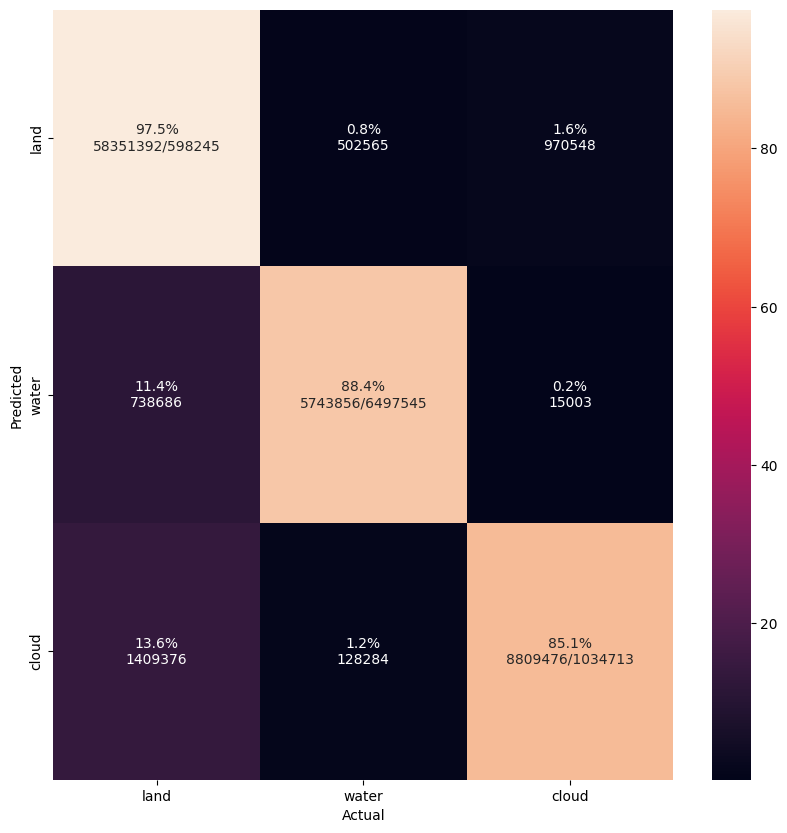

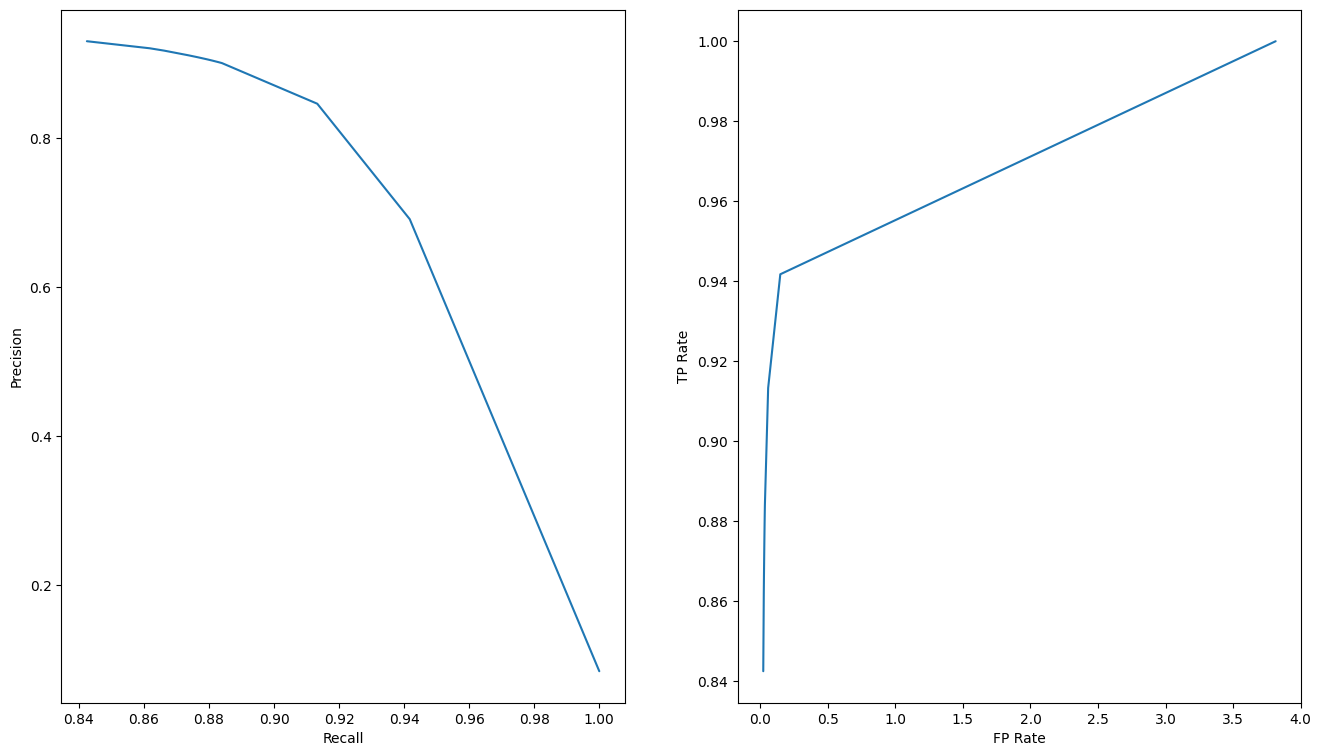

Per Class IOU {
    "cloud": 0.7773510377549276,
    "land": 0.9415680973809256,
    "water": 0.8057713981580993
}


In [19]:
# os.environ["CUDA_VISIBLE_DEVICES"]=""

# import torch
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

# model.to("cuda")
inference_function = get_model_inference_function(model, config, apply_normalization=False, activation="softmax")

# dataset2 = get_dataset(config.data_params)
dl = dataset.val_dataloader() # pytorch Dataloader
print(str(dl.batch_size))

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    plot=False, convert_targets=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

In [20]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 97.29060403993519, 'Recall_water': 78.81124042456447, 'Recall_cloud': 76.5909633624608, 'IoU_land': 94.67120356448204, 'IoU_water': 67.48144941094081, 'IoU_cloud': 67.98015632507915}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR271,96.009161,90.394657,91.135196,95.023210,61.535100,81.987778
EMSR279,94.516081,68.200009,84.177251,86.273968,57.290459,76.814110
EMSR280,99.350915,92.766773,79.109279,98.262007,89.018064,63.342188
EMSR287,99.902707,78.779671,16.409037,99.290703,76.863921,11.156023
RS2,95.714380,78.205517,93.079749,92.933057,59.286114,85.410482
ST1,98.250380,64.520816,95.635267,96.244276,60.895039,89.170356


In [21]:
torch.save(model.state_dict(),f"{experiment_path}/model_bgriswir_worldflood_model_1_epoch_40_gamma_5_alpha_0_001.pt")
# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config_bgriswir_worldflood_model_1_epoch_40_gamma_5_alpha_0_001.json"
import json
with open(config_file_path, 'w') as f:
    json.dump(config, f)

In [22]:
if setup_weights_and_biases:
    torch.save(model.state_dict(), os.path.join(wandb_logger.save_dir, 'model_bgriswir_worldflood_model_1_epoch_40_gamma_5_alpha_0_001.pt'))
    wandb.save(os.path.join(wandb_logger.save_dir, 'model_bgriswir_worldflood_model_1_epoch_40_gamma_5_alpha_0_001.pt')) # Copy weights to weights and biases server
    wandb.finish()

In [ ]:
# Run inference on the images shown before

logits = model(batch_val["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([8, 3, 256, 256])
Shape of probs: torch.Size([8, 3, 256, 256])
Shape of prediction: torch.Size([8, 256, 256])


(4, 1, 1)


ValueError: operands could not be broadcast together with shapes (1,5,256,256) (1,4,1,1) 

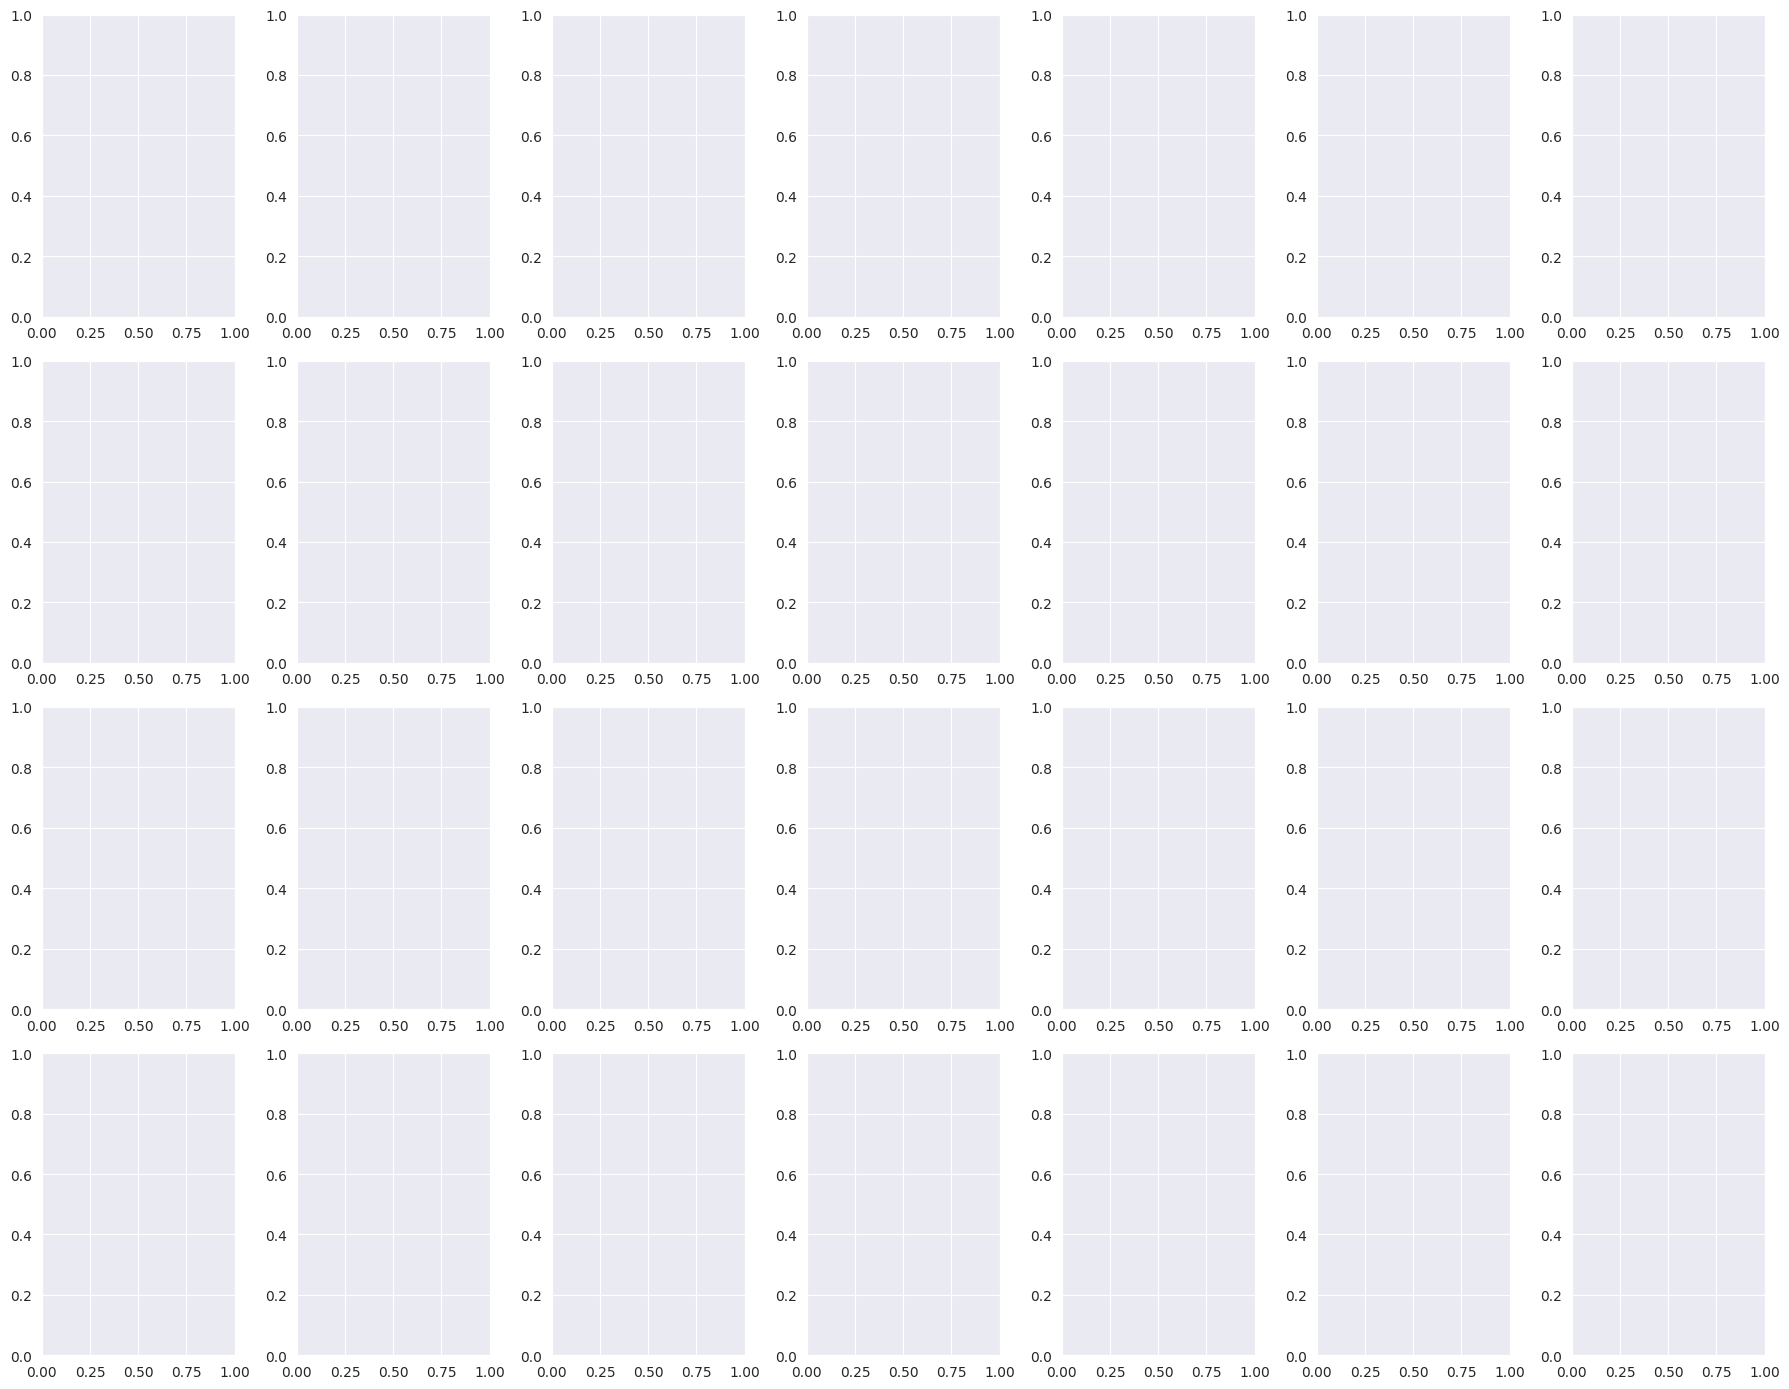

In [ ]:
n_image_start=7
n_images=14
count=int(n_images-n_image_start)
fig, axs = plt.subplots(4, count, figsize=(18,14),tight_layout=True)
importlib.reload(flooding_model)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",axs=axs[0],max_clip_val=3500.)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",bands_show=["B8","B8", "B8"],axs=axs[1],max_clip_val=3500.)
# flooding_model.plot_batch(batch_val["image"][:n_images],bands_show=["B11","B8", "B4"],axs=axs[1],max_clip_val=4500.)
flooding_model.plot_batch_output_v1(batch_val["mask"][n_image_start:n_images, 0],axs=axs[2], show_axis=True)
flooding_model.plot_batch_output_v1(prediction[n_image_start:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)